## Loading Training Data

In [2]:
import numpy as np
import pandas as pd

# read feature dataset
train_feat = np.load("datasets/train/train_feature.npz", allow_pickle=True)
train_feat_X = train_feat['features']
train_feat_Y = train_feat['label']

test_feat_X = np.load("datasets/test/test_feature.npz", allow_pickle=True)['features']

In [3]:
print(f"train_feat_X: {train_feat_X.shape} train_feat_Y: {train_feat_Y.shape}")
print(f"test_feat_X: {test_feat_X.shape}")

train_feat_X: (7080, 13, 768) train_feat_Y: (7080,)
test_feat_X: (2232, 13, 768)


## Model trained on the training data with PCA to extract top 50 (out of 768 features)

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Set the number of components to reduce the features to (e.g., 100)
n_components = 50

# Apply PCA to reduce the number of features from 768 to 100
pca = PCA(n_components=n_components)

# Reshape X to 2D (flatten the 13x768 feature matrix for PCA)
n_samples, n_time_steps, n_features = train_feat_X.shape  # train_feat_X has shape (n_samples, 13, 768)
X_flattened = train_feat_X.reshape(n_samples * n_time_steps, n_features)

# Apply PCA on the flattened data
X_reduced_flat = pca.fit_transform(X_flattened)

# Reshape back to 3D (with reduced features)
X_reduced = X_reduced_flat.reshape(n_samples, n_time_steps, n_components)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_reduced, train_feat_Y, test_size=0.3, random_state=42)

# Define the CNN model
model = models.Sequential()

# Adjust the input shape to reflect the reduced number of components
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(13, n_components), padding='same'))

# Add second Convolutional layer with padding='same' to prevent dimension reduction
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'))

# Add a Global Max Pooling layer to aggregate features over time steps without aggressive downsampling
model.add(layers.GlobalMaxPooling1D())

# Flatten the results for the Dense layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification output

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
155/155 [==============================] - 2s 10ms/step - loss: 0.4665 - accuracy: 0.8000 - val_loss: 0.1682 - val_accuracy: 0.9609
Epoch 2/10
155/155 [==============================] - 1s 8ms/step - loss: 0.1136 - accuracy: 0.9653 - val_loss: 0.0876 - val_accuracy: 0.9652
Epoch 3/10
155/155 [==============================] - 1s 9ms/step - loss: 0.0737 - accuracy: 0.9722 - val_loss: 0.0702 - val_accuracy: 0.9718
Epoch 4/10
155/155 [==============================] - 1s 8ms/step - loss: 0.0675 - accuracy: 0.9744 - val_loss: 0.0678 - val_accuracy: 0.9713
Epoch 5/10
155/155 [==============================] - 1s 8ms/step - loss: 0.0568 - accuracy: 0.9768 - val_loss: 0.0518 - val_accuracy: 0.9807
Epoch 6/10
155/155 [==============================] - 1s 8ms/step - loss: 0.0437 - accuracy: 0.9835 - val_loss: 0.0619 - val_accuracy: 0.9699
Epoch 7/10
155/155 [==============================] - 1s 8ms/step - loss: 0.0443 - accuracy: 0.9808 - val_loss: 0.0431 - val_accuracy: 0.9816
Epoch

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 32)            4832      
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 32)            3104      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                        

In [10]:
model.save('FeatureModel.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Loading Validation Set

In [6]:
valid_feat = np.load("datasets/valid/valid_feature.npz", allow_pickle=True)
valid_feat_X = valid_feat['features']
valid_feat_Y = valid_feat['label']

In [14]:
print(f"valid_feat_X: {valid_feat_X.shape}")

valid_feat_X: (489, 13, 768)


## Testing the accuracy on Validation Set

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

# Load the saved model (update with your saved model's path)
# model = load_model('feat_model_1.h5')

# Set the number of components used for PCA (should match what was used during training)
n_components = 50

# Apply PCA to reduce the validation set features from 768 to 50
pca = PCA(n_components=n_components)

# Flatten the validation data from 3D (n_samples, 13, 768) to 2D (n_samples * 13, 768)
n_samples, n_time_steps, n_features = valid_feat_X.shape  # Shape: (None, 13, 768)
valid_feat_X_flat = valid_feat_X.reshape(n_samples * n_time_steps, n_features)

# Apply PCA transformation (you need to have trained PCA on the training data earlier and re-use it here)
valid_feat_X_reduced_flat = pca.fit_transform(valid_feat_X_flat)  # Use the same PCA that was fit on training data

# Reshape back to 3D (n_samples, 13, n_components)
valid_feat_X_reduced = valid_feat_X_reduced_flat.reshape(n_samples, n_time_steps, n_components)

# Get predictions for the validation set
y_pred_val = (model.predict(valid_feat_X_reduced) > 0.5).astype("int32")

# If you have the true labels, calculate accuracy
if 'label' in valid_feat.files:
    valid_feat_Y = valid_feat['label']
    print(f"Validation Accuracy: {accuracy_score(valid_feat_Y, y_pred_val):.4f}")

# Save predictions to a file
np.savetxt('test_predictions.txt', y_pred_val, fmt='%d')

print("Predictions saved to test_predictions.txt")


16/16 [==============================] - 0s 5ms/step
Validation Accuracy: 0.9550
Predictions saved to test_predictions.txt


## RNN + LSTM

In [16]:
X_train, X_val, y_train, y_val = train_test_split(train_feat_X, train_feat_Y, test_size=0.2, random_state=42)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
lstm_model = Sequential()

# Add an LSTM layer
lstm_model.add(LSTM(16, return_sequences=True, input_shape=(13, n_components)))

# Add a second LSTM layer
lstm_model.add(LSTM(8))

# Add a Dropout layer to prevent overfitting
lstm_model.add(Dropout(0.2))

# Dense layers
lstm_model.add(Dense(8, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))  # Binary classification output

# Compile the model
lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Train the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
177/177 [==============================] - 5s 16ms/step - loss: 0.6153 - accuracy: 0.6580 - val_loss: 0.4859 - val_accuracy: 0.7691
Epoch 2/10
177/177 [==============================] - 2s 12ms/step - loss: 0.3018 - accuracy: 0.8838 - val_loss: 0.1449 - val_accuracy: 0.9612
Epoch 3/10
177/177 [==============================] - 2s 12ms/step - loss: 0.1193 - accuracy: 0.9553 - val_loss: 0.0874 - val_accuracy: 0.9682
Epoch 4/10
177/177 [==============================] - 2s 12ms/step - loss: 0.0835 - accuracy: 0.9666 - val_loss: 0.0663 - val_accuracy: 0.9732
Epoch 5/10
177/177 [==============================] - 2s 12ms/step - loss: 0.0663 - accuracy: 0.9733 - val_loss: 0.0553 - val_accuracy: 0.9767
Epoch 6/10
177/177 [==============================] - 2s 12ms/step - loss: 0.0600 - accuracy: 0.9744 - val_loss: 0.0490 - val_accuracy: 0.9823
Epoch 7/10
177/177 [==============================] - 2s 12ms/step - loss: 0.0549 - accuracy: 0.9763 - val_loss: 0.0527 - val_accuracy: 0.9725

In [33]:
lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 13, 16)            4288      
                                                                 
 lstm_17 (LSTM)              (None, 8)                 800       
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_20 (Dense)            (None, 8)                 72        
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5169 (20.19 KB)
Trainable params: 5169 (20.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# Evaluate on the separate validation set
lstm_val_predictions = (lstm_model.predict(valid_feat_X_reduced) > 0.5).astype(int)
lstm_val_accuracy = accuracy_score(valid_feat_Y, lstm_val_predictions)
print(f"LSTM Model Validation Accuracy: {lstm_val_accuracy:.4f}")


16/16 [==============================] - 1s 6ms/step
LSTM Model Validation Accuracy: 0.9407


## Bi-LSTM

In [38]:
from tensorflow.keras.layers import Bidirectional

# Define the Bidirectional LSTM model
bi_lstm_model = Sequential()

# Add a Bidirectional LSTM layer
bi_lstm_model.add(Bidirectional(LSTM(16, return_sequences=True), input_shape=(13, n_components)))

# Add a second Bidirectional LSTM layer
bi_lstm_model.add(Bidirectional(LSTM(8)))

# Add a Dropout layer
bi_lstm_model.add(Dropout(0.3))

# Dense layers
bi_lstm_model.add(Dense(8, activation='relu'))
bi_lstm_model.add(Dense(1, activation='sigmoid'))  # Binary classification output

# Compile the model
bi_lstm_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Train the model
bi_lstm_history = bi_lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
177/177 [==============================] - 8s 30ms/step - loss: 0.5650 - accuracy: 0.6937 - val_loss: 0.1722 - val_accuracy: 0.9357
Epoch 2/10
177/177 [==============================] - 4s 23ms/step - loss: 0.1240 - accuracy: 0.9492 - val_loss: 0.0884 - val_accuracy: 0.9597
Epoch 3/10
177/177 [==============================] - 4s 23ms/step - loss: 0.0935 - accuracy: 0.9610 - val_loss: 0.0665 - val_accuracy: 0.9710
Epoch 4/10
177/177 [==============================] - 4s 23ms/step - loss: 0.0805 - accuracy: 0.9668 - val_loss: 0.0548 - val_accuracy: 0.9760
Epoch 5/10
177/177 [==============================] - 4s 24ms/step - loss: 0.0598 - accuracy: 0.9735 - val_loss: 0.0545 - val_accuracy: 0.9781
Epoch 6/10
177/177 [==============================] - 4s 23ms/step - loss: 0.0554 - accuracy: 0.9753 - val_loss: 0.0454 - val_accuracy: 0.9823
Epoch 7/10
177/177 [==============================] - 4s 23ms/step - loss: 0.0560 - accuracy: 0.9758 - val_loss: 0.0466 - val_accuracy: 0.9774

In [37]:
bi_lstm_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 13, 128)           58880     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 102209 (399.25 KB)
Trainable params: 10

In [39]:
bilstm_val_predictions = (bi_lstm_model.predict(valid_feat_X_reduced) > 0.5).astype(int)
bilstm_val_accuracy = accuracy_score(valid_feat_Y, bilstm_val_predictions)
print(f"LSTM Model Validation Accuracy: {bilstm_val_accuracy:.4f}")

16/16 [==============================] - 1s 13ms/step
LSTM Model Validation Accuracy: 0.9448


## GRU

In [65]:
from tensorflow.keras.layers import GRU

# Define the GRU model
gru_model = Sequential()

# Add a GRU layer
gru_model.add(GRU(32, return_sequences=True, input_shape=(13, n_components)))

# Add a second GRU layer
gru_model.add(GRU(8))

# Add a Dropout layer
gru_model.add(Dropout(0.2))

# Dense layers
gru_model.add(Dense(8, activation='relu'))
gru_model.add(Dense(1, activation='sigmoid'))  # Binary classification output

# Compile the model
gru_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
gru_history = gru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
177/177 [==============================] - 4s 15ms/step - loss: 0.5137 - accuracy: 0.7594 - val_loss: 0.1879 - val_accuracy: 0.9477
Epoch 2/10
177/177 [==============================] - 2s 12ms/step - loss: 0.1162 - accuracy: 0.9608 - val_loss: 0.0867 - val_accuracy: 0.9682
Epoch 3/10
177/177 [==============================] - 2s 12ms/step - loss: 0.0710 - accuracy: 0.9732 - val_loss: 0.0804 - val_accuracy: 0.9605
Epoch 4/10
177/177 [==============================] - 2s 11ms/step - loss: 0.0573 - accuracy: 0.9763 - val_loss: 0.0539 - val_accuracy: 0.9802
Epoch 5/10
177/177 [==============================] - 2s 11ms/step - loss: 0.0537 - accuracy: 0.9781 - val_loss: 0.0698 - val_accuracy: 0.9661
Epoch 6/10
177/177 [==============================] - 2s 11ms/step - loss: 0.0481 - accuracy: 0.9804 - val_loss: 0.0516 - val_accuracy: 0.9788
Epoch 7/10
177/177 [==============================] - 2s 12ms/step - loss: 0.0453 - accuracy: 0.9815 - val_loss: 0.0437 - val_accuracy: 0.9788

In [48]:
gru_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 13, 32)            8064      
                                                                 
 gru_5 (GRU)                 (None, 8)                 1008      
                                                                 
 dropout_14 (Dropout)        (None, 8)                 0         
                                                                 
 dense_32 (Dense)            (None, 8)                 72        
                                                                 
 dense_33 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9153 (35.75 KB)
Trainable params: 9153 (35.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
gru_val_predictions = (gru_model.predict(valid_feat_X_reduced) > 0.5).astype(int)
gru_val_accuracy = accuracy_score(valid_feat_Y, gru_val_predictions)
print(f"GRU Model Validation Accuracy: {gru_val_accuracy:.4f}")

16/16 [==============================] - 1s 7ms/step
GRU Model Validation Accuracy: 0.9550


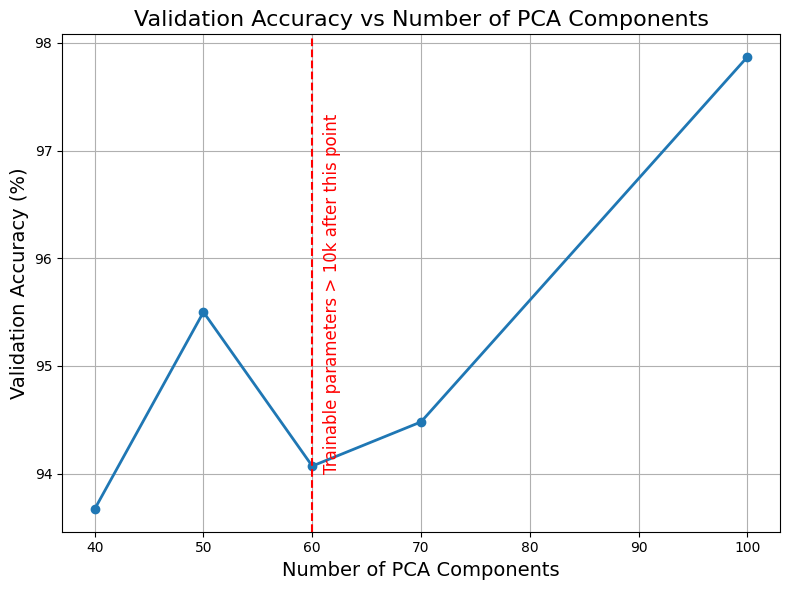

In [77]:
import matplotlib.pyplot as plt

x_values = [40, 50, 60, 70, 100]
y_values = [93.67, 95.50, 94.07, 94.48, 97.87]

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', linewidth=2)
plt.axvline(x=60, color='red', linestyle='--', linewidth=1.5, label='x = 60')
plt.text(61, 94, 'Trainable parameters > 10k after this point', color='red', fontsize=12, rotation=90, va='bottom')
plt.xlabel('Number of PCA Components', fontsize=14)
plt.ylabel('Validation Accuracy (%)', fontsize=14)
plt.title('Validation Accuracy vs Number of PCA Components', fontsize=16)
plt.grid(True)
plt.tight_layout()

# Display the graph
plt.show()


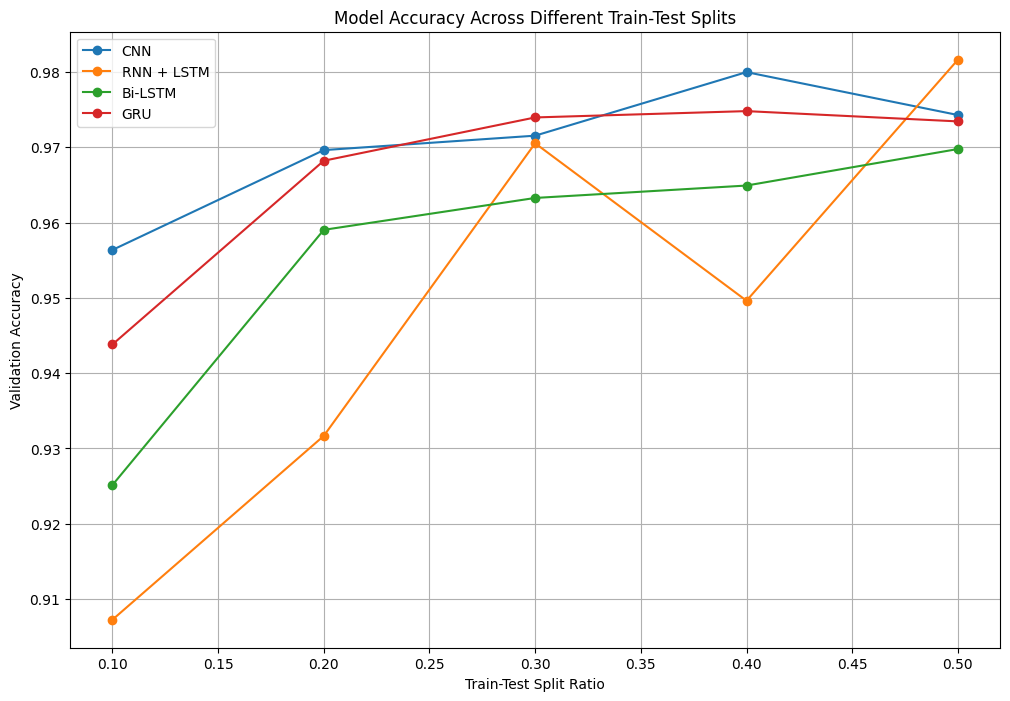

In [81]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dropout, Dense
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set the number of components for PCA reduction
n_components = 50

# List of train-test split ratios
split_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]

# Store results
model_names = ['CNN', 'RNN + LSTM', 'Bi-LSTM', 'GRU']
accuracy_results = {model: [] for model in model_names}

# Define a function to apply PCA
def apply_pca(X, n_components):
    n_samples, n_time_steps, n_features = X.shape
    X_flattened = X.reshape(n_samples * n_time_steps, n_features)
    pca = PCA(n_components=n_components)
    X_reduced_flat = pca.fit_transform(X_flattened)
    X_reduced = X_reduced_flat.reshape(n_samples, n_time_steps, n_components)
    return X_reduced

# Define a function to compile and train the model
def compile_and_train_model(model, X_train, X_val, y_train, y_val):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    return history.history['val_accuracy'][-1]

# Define CNN model
def get_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        layers.GlobalMaxPooling1D(),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Define RNN + LSTM model
def get_rnn_lstm_model(input_shape):
    model = Sequential([
        LSTM(16, return_sequences=True, input_shape=input_shape),
        LSTM(8),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Define Bi-LSTM model
def get_bi_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(16, return_sequences=True), input_shape=input_shape),
        Bidirectional(LSTM(8)),
        Dropout(0.3),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Define GRU model
def get_gru_model(input_shape):
    model = Sequential([
        GRU(32, return_sequences=True, input_shape=input_shape),
        GRU(8),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Iterate over each train-test split
for split_ratio in split_ratios:
    # Apply PCA on the original dataset
    X_reduced = apply_pca(train_feat_X, n_components)
    
    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_reduced, train_feat_Y, test_size=1-split_ratio, random_state=42)
    
    # Get input shape
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Train CNN
    cnn_model = get_cnn_model(input_shape)
    cnn_accuracy = compile_and_train_model(cnn_model, X_train, X_val, y_train, y_val)
    accuracy_results['CNN'].append(cnn_accuracy)
    
    # Train RNN + LSTM
    rnn_lstm_model = get_rnn_lstm_model(input_shape)
    rnn_lstm_accuracy = compile_and_train_model(rnn_lstm_model, X_train, X_val, y_train, y_val)
    accuracy_results['RNN + LSTM'].append(rnn_lstm_accuracy)
    
    # Train Bi-LSTM
    bi_lstm_model = get_bi_lstm_model(input_shape)
    bi_lstm_accuracy = compile_and_train_model(bi_lstm_model, X_train, X_val, y_train, y_val)
    accuracy_results['Bi-LSTM'].append(bi_lstm_accuracy)
    
    # Train GRU
    gru_model = get_gru_model(input_shape)
    gru_accuracy = compile_and_train_model(gru_model, X_train, X_val, y_train, y_val)
    accuracy_results['GRU'].append(gru_accuracy)

# Plotting the results
plt.figure(figsize=(12, 8))
for model_name in model_names:
    plt.plot(split_ratios, accuracy_results[model_name], label=model_name, marker='o')

plt.title('Model Accuracy Across Different Train-Test Splits')
plt.xlabel('Train-Test Split Ratio')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


16/16 [==============================] - 1s 13ms/step


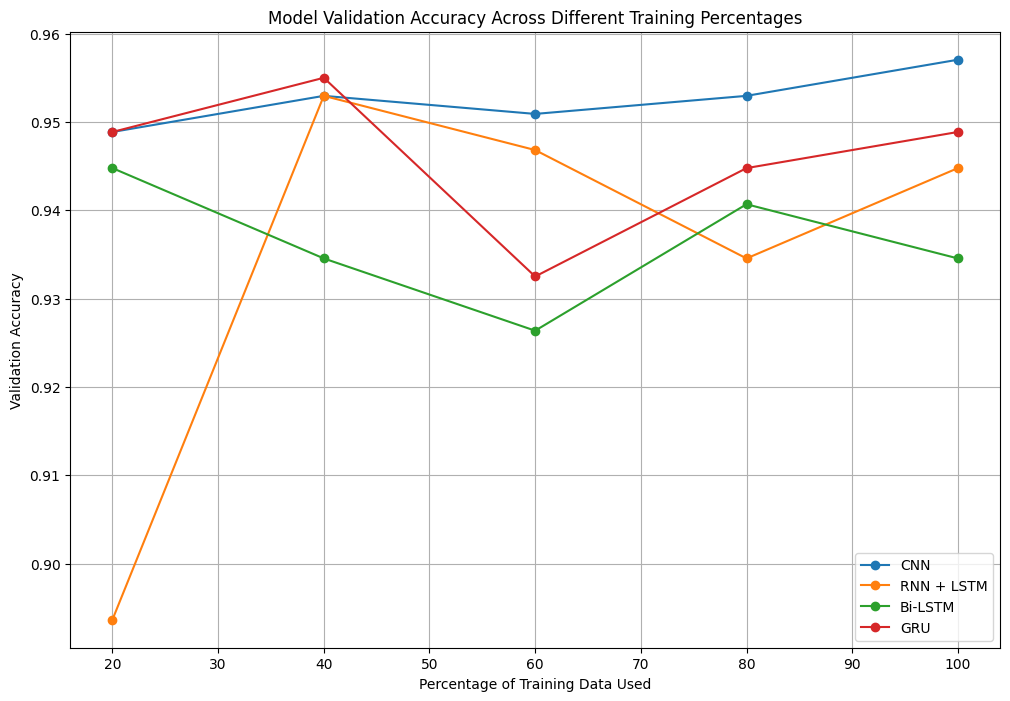

In [88]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dropout, Dense
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set the number of components for PCA reduction
n_components = 50

# Define the percentages of training data to use
train_percentages = [0.2, 0.4, 0.6, 0.8, 1.0]

# Store results
model_names = ['CNN', 'RNN + LSTM', 'Bi-LSTM', 'GRU']
accuracy_results = {model: [] for model in model_names}

# Apply PCA to the original dataset
X_reduced = apply_pca(train_feat_X, n_components)

# Split into train and validation sets (constant)
X_train, X_val, y_train, y_val = train_test_split(X_reduced, train_feat_Y, test_size=0.2, random_state=42)

# Apply PCA on the validation set
valid_feat_X_reduced = apply_pca(valid_feat_X, n_components)

# Define a function to compile and train the model
def compile_and_train_model(model, X_train, y_train):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Iterate over each percentage of training data
for train_percentage in train_percentages:
    # Calculate the number of samples to use from the training set
    n_samples = int(train_percentage * X_train.shape[0])
    X_train_subset = X_train[:n_samples]
    y_train_subset = y_train[:n_samples]
    
    # Get input shape
    input_shape = (X_train_subset.shape[1], X_train_subset.shape[2])
    
    # Train and evaluate CNN
    cnn_model = get_cnn_model(input_shape)
    compile_and_train_model(cnn_model, X_train_subset, y_train_subset)
    cnn_val_predictions = (cnn_model.predict(valid_feat_X_reduced) > 0.5).astype(int)
    cnn_val_accuracy = accuracy_score(valid_feat_Y, cnn_val_predictions)
    accuracy_results['CNN'].append(cnn_val_accuracy)

    # Train and evaluate RNN + LSTM
    rnn_lstm_model = get_rnn_lstm_model(input_shape)
    compile_and_train_model(rnn_lstm_model, X_train_subset, y_train_subset)
    rnn_lstm_val_predictions = (rnn_lstm_model.predict(valid_feat_X_reduced) > 0.5).astype(int)
    rnn_lstm_val_accuracy = accuracy_score(valid_feat_Y, rnn_lstm_val_predictions)
    accuracy_results['RNN + LSTM'].append(rnn_lstm_val_accuracy)

    # Train and evaluate Bi-LSTM
    bi_lstm_model = get_bi_lstm_model(input_shape)
    compile_and_train_model(bi_lstm_model, X_train_subset, y_train_subset)
    bi_lstm_val_predictions = (bi_lstm_model.predict(valid_feat_X_reduced) > 0.5).astype(int)
    bi_lstm_val_accuracy = accuracy_score(valid_feat_Y, bi_lstm_val_predictions)
    accuracy_results['Bi-LSTM'].append(bi_lstm_val_accuracy)

    # Train and evaluate GRU
    gru_model = get_gru_model(input_shape)
    compile_and_train_model(gru_model, X_train_subset, y_train_subset)
    gru_val_predictions = (gru_model.predict(valid_feat_X_reduced) > 0.5).astype(int)
    gru_val_accuracy = accuracy_score(valid_feat_Y, gru_val_predictions)
    accuracy_results['GRU'].append(gru_val_accuracy)

# Plotting the results
plt.figure(figsize=(12, 8))
for model_name in model_names:
    plt.plot([int(p * 100) for p in train_percentages], accuracy_results[model_name], label=model_name, marker='o')

plt.title('Model Validation Accuracy Across Different Training Percentages')
plt.xlabel('Percentage of Training Data Used')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Final Code

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


n_components = 50


pca = PCA(n_components=n_components)

# Reshape X to 2D (flatten the 13x768 feature matrix for PCA)
n_samples, n_time_steps, n_features = train_feat_X.shape  # train_feat_X has shape (n_samples, 13, 768)
X_flattened = train_feat_X.reshape(n_samples * n_time_steps, n_features)

# Apply PCA on the flattened data
X_reduced_flat = pca.fit_transform(X_flattened)

# Reshape back to 3D (with reduced features)
X_reduced = X_reduced_flat.reshape(n_samples, n_time_steps, n_components)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_reduced, train_feat_Y, test_size=0.3, random_state=42)

# Define the CNN model
model = models.Sequential()

# Adjust the input shape to reflect the reduced number of components
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(13, n_components), padding='same'))

# Add second Convolutional layer with padding='same' to prevent dimension reduction
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'))

# Add a Global Max Pooling layer to aggregate features over time steps without aggressive downsampling
model.add(layers.GlobalMaxPooling1D())

# Flatten the results for the Dense layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification output

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))



valid_feat = np.load("datasets/valid/valid_feature.npz", allow_pickle=True)
valid_feat_X = valid_feat['features']
valid_feat_Y = valid_feat['label']

# Load the saved model (update with your saved model's path)
# model = load_model('feat_model_1.h5')

# Set the number of components used for PCA (should match what was used during training)
n_components = 50

# Apply PCA to reduce the validation set features from 768 to 50
pca = PCA(n_components=n_components)

# Flatten the validation data from 3D (n_samples, 13, 768) to 2D (n_samples * 13, 768)
n_samples, n_time_steps, n_features = valid_feat_X.shape  # Shape: (None, 13, 768)
valid_feat_X_flat = valid_feat_X.reshape(n_samples * n_time_steps, n_features)

# Apply PCA transformation (you need to have trained PCA on the training data earlier and re-use it here)
valid_feat_X_reduced_flat = pca.fit_transform(valid_feat_X_flat)  # Use the same PCA that was fit on training data

# Reshape back to 3D (n_samples, 13, n_components)
valid_feat_X_reduced = valid_feat_X_reduced_flat.reshape(n_samples, n_time_steps, n_components)

# Get predictions for the validation set
y_pred_val = (model.predict(valid_feat_X_reduced) > 0.5).astype("int32")

# If you have the true labels, calculate accuracy
if 'label' in valid_feat.files:
    valid_feat_Y = valid_feat['label']
    print(f"Validation Accuracy: {accuracy_score(valid_feat_Y, y_pred_val):.4f}")

# Save predictions to a file
np.savetxt('test_predictions.txt', y_pred_val, fmt='%d')

print("Predictions saved to test_predictions.txt")